In [243]:
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import shape, LineString
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

% matplotlib inline

In [31]:
# Load the data matrices (NB 2 parts due to restrictions on download size from nomis)
# Columns are Waltham Forest 2011 LSOAs - home locations
# Rows are Workplace zones for all of London, and proximal East and South East region.

# Part 1
part1 = pd.read_csv('../Data/274122159.csv',header=7,skip_blank_lines=True)
part1.drop(' ',axis=1, inplace=True)
part1.rename(columns= {' .1':'wz2011'},inplace = True)

#Part 2
part2 = pd.read_csv('../Data/2353810085.csv',header=7,skip_blank_lines=True)
part2.drop(' ',axis=1, inplace=True)
part2.rename(columns= {' .1':'wz2011'},inplace = True)

# Merge the datasets by wz2011
flows = part1.merge(part2, on= 'wz2011')
# Remove disclosure control warning from end of dataset
flows = flows[:-4]
flows.head()

,wz2011,E01004412,E01004465,E01004466,E01004467,E01004468,E01004406,E01004408,E01004409,E01004411,...,E01004410,E01004464,E01004469,E01004470,E01004471,E01004391,E01004393,E01004401,E01004404,E01004461
0,E33032182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E33032183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E33032184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E33029031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,E33032185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Total number of flows in data: 91,785 flows.
flows.drop('wz2011',axis=1).values.sum()

91785.0

In [58]:
# Let's get the workplace zone (wz) and lsoa geographies to get an idea of the flow lengths.
# lsoas
lsoa_url  = "https://opendata.arcgis.com/datasets/da831f80764346889837c72508f046fa_0.geojson"
# Access data with requests, take features info direct from the json
lsoa_json = requests.get(lsoa_url).json()['features']
# Each lsoa has 3 pieces of information: geometry, type, and properties.
# We can ignore type here, geometry is self explanatory, properties are our attributes.
# To put the data into geopandas we need to split it into geometry and attribute lists.
# geometry - list of shapely geometries
geom = [shape(d['geometry']) for d in lsoa_json]
# Attributes - list of dictionaries
attr = [d['properties'] for d in lsoa_json]

# Now put data into geopandas geodataframe, set input crs to WGS84
lsoas = gpd.GeoDataFrame(attr, geometry = geom, crs = {'init':'epsg:4326'})

# Finally, because we know we'll be measuring distances later, we'll project to the British National Grid.
lsoas = lsoas.to_crs({'init':'epsg:27700'})

# WZ
wz_url = "https://opendata.arcgis.com/datasets/a399c2a5922a4beaa080de63c0a218a3_0.geojson"
# Access data with requests, take features info direct from the json
wz_json = requests.get(wz_url).json()['features']
# Each lsoa has 3 pieces of information: geometry, type, and properties.
# We can ignore type here, geometry is self explanatory, properties are our attributes.
# To put the data into geopandas we need to split it into geometry and attribute lists.
# geometry - list of shapely geometries
geom = [shape(d['geometry']) for d in wz_json]
# Attributes - list of dictionaries
attr = [d['properties'] for d in wz_json]

# Now put data into geopandas geodataframe, set input crs to WGS84
wz = gpd.GeoDataFrame(attr, geometry = geom, crs = {'init':'epsg:4326'})

# Finally, because we know we'll be measuring distances later, we'll project to the British National Grid.
wz = wz.to_crs({'init':'epsg:27700'})

In [60]:
# Now I'll just subset out the LSOAs that belong to Waltham Forest.
WFlsoas = flows.columns[1:]
wf_lsoas = lsoas[lsoas['lsoa11cd'].isin(WFlsoas)]

# And the workplace zones that we're considering.
WFwzs = flows['wz2011'].values
wf_wzs = wz[wz['wz11cd'].isin(WFwzs)]

Text(0.5,1,'Workplace Zones surrounding Waltham Forest, 2011')

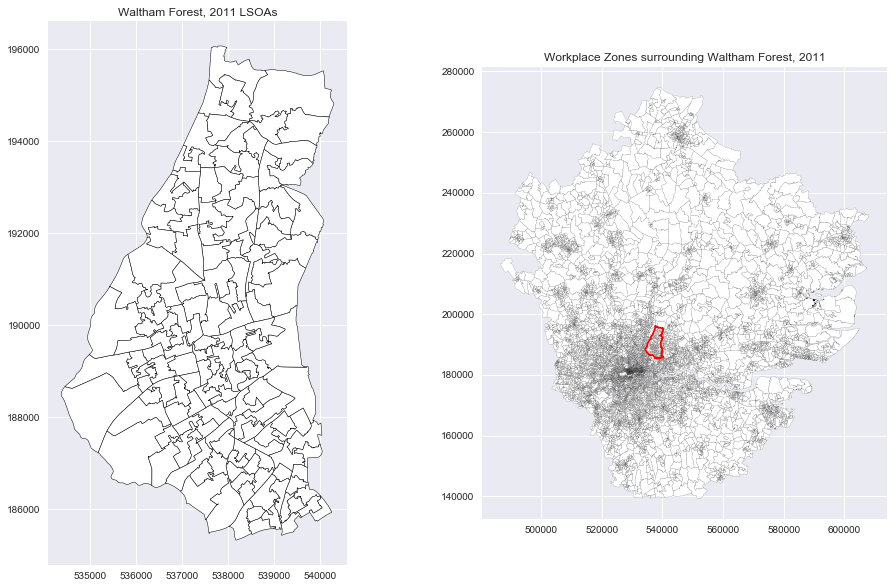

In [196]:
# Let's have a quick look at the areas that we're considering.
f, [ax1,ax2] = plt.subplots(1,2, figsize=(16,10))

# plot lsoas
wf_lsoas.plot(ax=ax1,edgecolor='k',facecolor='w',lw=0.5)
ax1.set_aspect('equal')
ax1.set_title('Waltham Forest, 2011 LSOAs')

# plot workplace zones
wf_wzs.plot(ax=ax2,edgecolor='k',facecolor='w',lw=0.1)
ax2.set_aspect('equal')
# add Waltham Forest outline to plot
WF = gpd.GeoDataFrame({'name':'Waltham Forest'}, index=[0], geometry = [wf_lsoas.unary_union], crs = {'init':'epsg:27700'})
WF.boundary.plot(ax=ax2,edgecolor='r')

ax2.set_title('Workplace Zones surrounding Waltham Forest, 2011')

In [120]:
# Now let's convert the flow matrix to a pairwise structure.
# First melt the dataframe
flows_melt = pd.melt(flows,id_vars=['wz2011'],value_vars=WFlsoas,var_name='lsoa11cd',value_name='flows')
# Remove the zero flows
flows_melt = flows_melt[flows_melt['flows'] > 0]
flows_melt.reset_index(drop=True,inplace=True)
# unbundle the multiple flows
flows_melt = pd.DataFrame([flows_melt.iloc[idx] 
                           for idx in flows_melt.index 
                           for _ in range(int(flows_melt.iloc[idx]['flows']))]).reset_index(drop=True)
# Finally, drop the now irrelevant flow count field
flows_melt.drop('flows',axis=1,inplace=True)

In [166]:
# Now lets work out the Euclidean distances between origin and destination centroids
# First make centroid representations of the geospatial data
p_wzs = gpd.GeoDataFrame(wf_wzs[wf_wzs.columns[:-1]],geometry=wf_wzs.centroid)
p_lsoas = gpd.GeoDataFrame(wf_lsoas[wf_lsoas.columns[:-1]],geometry=wf_lsoas.centroid)

# NB this takes a (long) while because doing this many selections is really inefficient!
# I should've just stored the x and y coordinates in the table first.
flows_melt['distance'] = flows_melt.apply(lambda x:  p_wzs[p_wzs['wz11cd'] == x['wz2011']].distance(
    p_lsoas[p_lsoas['lsoa11cd'] == x['lsoa11cd']]['geometry'].values[0]).values[0],axis =1)

In [170]:
# Let's have a look at the travel to work distances.
flows_melt.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,91785.0,8910.762793,6877.791189,0.000028,3912.078059,8412.804878,11903.106529,77124.076771


C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


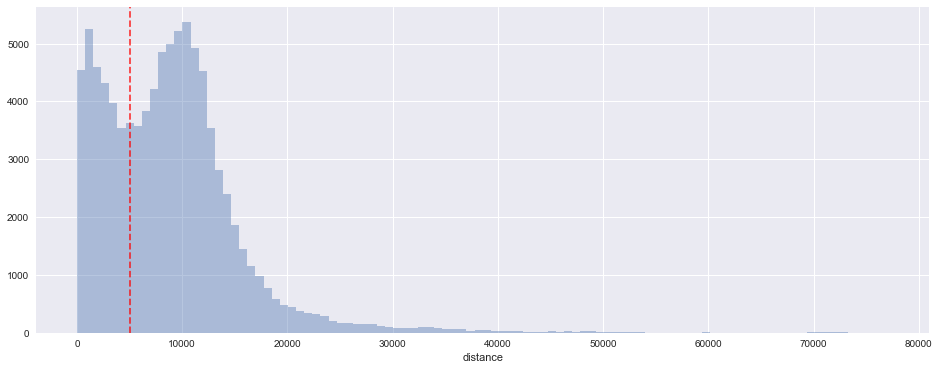

In [192]:
# Let's look at the distribution of travel to work
f, ax = plt.subplots(figsize=(16,6))

sns.distplot(flows_melt['distance'],kde=False,bins=100)
ax.axvline(x=5000,color= 'r',linestyle='dashed',alpha=0.75)

In [345]:
# A helper function for drawing flows
def _odline(orig,dest,origgeo,destgeo,origzonecode,destzonecode):
    return LineString([origgeo[origgeo[origzonecode] == orig].centroid.values[0],destgeo[destgeo[destzonecode] == dest].centroid.values[0]])

# Makes a geodataframe of flows
# Suffers from the same speed issues as previous function.
def odflow(flowdata,origin,destination,origgeo,origzonecode,flow_value = None,destgeo=None,destzonecode=None):
    
    if destgeo is not None:
        if destgeo.crs != origgeo.crs:
            print "CRS of origin and destination geographies must match!"
            return None
    else:
        # If origin and destination geographies are the same, remove need to input twice.
        destgeo = origgeo
        destzonecode = origzonecode

    # Make all the lines
    lines = flowdata.apply(lambda x: _odline(x[origin],x[destination],origgeo,destgeo,origzonecode,destzonecode), axis=1)
    # If flows have different weights
    
    if flow_value:
        # Now get the series of flow values
        flows = flowdata[[origin,destination,flow_value]]
    else:
        flows = flowdata[[origin,destination]]
    
    # Now return a geodataframe
    return gpd.GeoDataFrame(flows,geometry=lines,crs = origgeo.crs)


# OK. Let's explore this double hump distribution a little.
# The first dip is at 5km. - That's around 30% of flows.
flows5km = flows_melt[flows_melt['distance'] <=5000]

flow_lines5km = odflow(flows5km,'lsoa11cd','wz2011',wf_lsoas,'lsoa11cd',None,wf_wzs,'wz11cd')

In [223]:
# Get some district information
boro_url  = "https://opendata.arcgis.com/datasets/fab4feab211c4899b602ecfbfbc420a3_0.geojson"
boro_json = requests.get(boro_url).json()['features']
geom = [shape(d['geometry']) for d in boro_json]
attr = [d['properties'] for d in boro_json]
boros = gpd.GeoDataFrame(attr, geometry = geom, crs = {'init':'epsg:4326'})
boros = boros.to_crs({'init':'epsg:27700'})

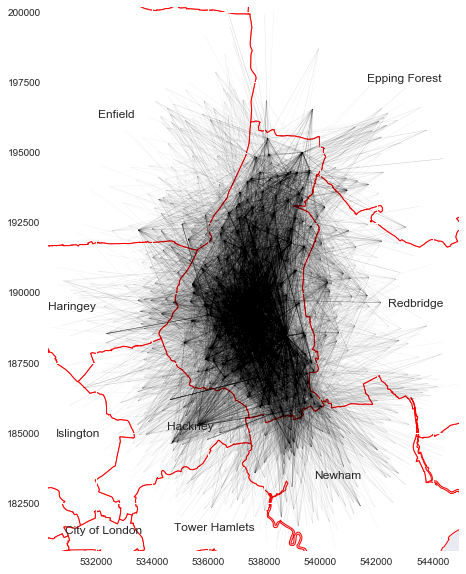

In [500]:
# Now let's look at the spatial distribution of the flow lines.

f, ax = plt.subplots(figsize=(10,10))

flow_lines5km.plot(lw=0.5,color='k',alpha=0.05,ax=ax,zorder=1)
boros.plot(ax=ax, facecolor='w',edgecolor='r',lw=1, zorder=0)

# Get boundary coordinates
xs = np.stack(flow_lines5km['geometry'].apply(lambda x: sorted([x.coords[0][0],x.coords[1][0]])).values)
ys = np.stack(flow_lines5km['geometry'].apply(lambda x: sorted([x.coords[0][1],x.coords[1][1]])).values)
minx,maxx,miny,maxy = xs[:,0].min(),xs[:,1].max(),ys[:,0].min(),ys[:,1].max()

ax.set_xlim([minx,maxx])
ax.set_ylim([miny,maxy])
ax.set_aspect('equal')

# Add some boro labels.
# subset boros to annotate.
annotate_boros = boros[boros['lad17nm'].isin(['City of London','Hackney','Tower Hamlets','Newham','Haringey',
                             'Islington','Enfield','Redbridge','Epping Forest'])]
for idx, row in annotate_boros.iterrows():
    if row['lad17nm'] == 'Epping Forest':
        point = [543000,197500]
    else:
        point = row['geometry'].representative_point().coords[:][0]
    ax.text(x=point[0],y=point[1],s=row['lad17nm'],ha='center',fontsize=12)


C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


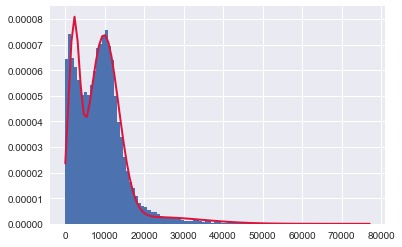

In [517]:
# Fit the distribution of commuting distance as a gaussian mixture model.
from sklearn.mixture import GaussianMixture

# 3 components works pretty well.
gmm = GaussianMixture(n_components=3)
gmm = gmm.fit(X = np.expand_dims(flows_melt['distance'],1))

# Evaluate GMM
gmm_x = np.linspace(0,flows_melt['distance'].max(),100)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

fig, ax = plt.subplots()
ax.hist(flows_melt['distance'],bins=100,normed=True)
ax.plot(gmm_x, gmm_y, color="crimson", lw=2, label="GMM")

In [493]:
# means = 9845.09054289; 2205.44681457; 22606.84196648
# covariances = 13629484.66480519; 2000457.67391085; 143161746.89321038
# weights = 0.66987177; 0.25230344; 0.07782479

from scipy.stats import norm
distribs = [norm(mean, np.sqrt(covariance)) for (mean, covariance) in zip(gmm.means_, gmm.covariances_)]
pick = np.cumsum(gmm.weights_)
new_data = []
for i in range(0,len(flows_melt)):
    rn = np.random.rand()
    if rn < pick[0]:
        new_data.append(abs(distribs[0].rvs()))
    elif rn < pick[1]:
        new_data.append(abs(distribs[1].rvs()))
    else:
        new_data.append(abs(distribs[2].rvs()))
        
# NB I'm taking the absolute values of the random draws to avoid negative values, this is a hack.
# Should probably be using a mixture model of distributions which are positive only.

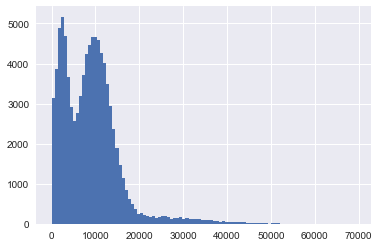

In [509]:
plt.hist(new_data,bins=100);

In [510]:
# See the data generating mechanism performs agains the data itself
np.corrcoef(sorted(flows_melt['distance']),sorted(new_data))

array([[ 1.        ,  0.99358861],
       [ 0.99358861,  1.        ]])

Text(0,0.5,'Synthetic Commute Distance (m)')

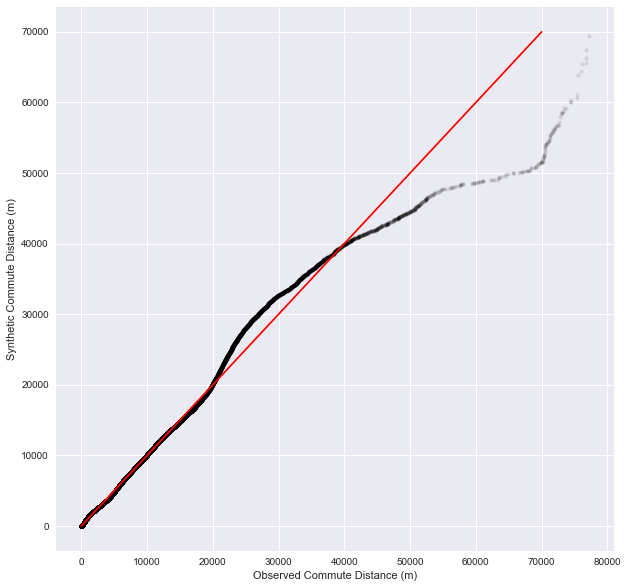

In [513]:
f, ax = plt.subplots(figsize=(10,10))

ax.scatter(sorted(flows_melt['distance']),sorted(new_data),marker='.', color='k',alpha=0.1)
ax.plot([0,70000],[0,70000],color='r')
ax.set_xlabel("Observed Commute Distance (m)")
ax.set_ylabel("Synthetic Commute Distance (m)")

# NB - most of the data lie below 20km (c.95%) so this is actually pretty good.

In [535]:
# Finally, let's look at the predictions
flows_melt['predict'] = gmm.predict(np.expand_dims(flows_melt['distance'],1))

flows_melt.groupby('predict')['distance'].describe()

,count,mean,std,min,25%,50%,75%,max
predict,,,,,,,,
0,24494.0,2021.992905,1182.738134,0.000028,983.629649,1939.866289,3024.860776,4240.976910
1,4777.0,28434.768148,10132.154405,19459.740632,21537.504439,24780.666997,31982.742779,77124.076771
2,62514.0,10117.970076,3447.032706,4241.291101,7459.701483,9920.321120,12346.909101,19457.412495


The 3 distributions in the mixture model cut the data in the following way.

Group 0 (Local) - 27% of data. Ranging from 0 to 4,241m commutes.
Group 2 (City) - 68% of data. Ranging from 4,241m to 19,457m commutes.
Group 1 (Region) - 5% of data. Commutes over 19,457m.

Text(0.5,1,'Work Destinations. Region Group. 5% of Commutes')

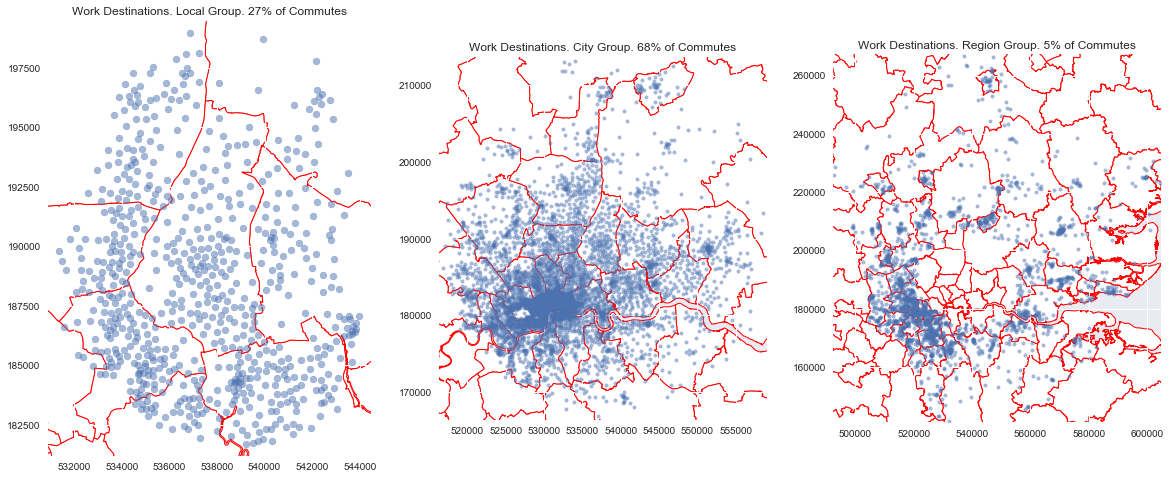

In [561]:
# Let's see what those groups correspond to in terms of workplace locations
grp_0_wzs = np.unique(flows_melt[flows_melt['predict']==0]['wz2011'])
grp_1_wzs = np.unique(flows_melt[flows_melt['predict']==1]['wz2011'])
grp_2_wzs = np.unique(flows_melt[flows_melt['predict']==2]['wz2011'])

f, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(20,8))

# Local
p_wzs[p_wzs['wz11cd'].isin(grp_0_wzs)].plot(ax=ax1,alpha=0.5)
boros.plot(ax=ax1, facecolor='w',edgecolor='r',lw=1, zorder=0)
ax1.set_aspect('equal')
xs = p_wzs[p_wzs['wz11cd'].isin(grp_0_wzs)]['geometry'].x
ys = p_wzs[p_wzs['wz11cd'].isin(grp_0_wzs)]['geometry'].y
minx,maxx,miny,maxy = xs.min(),xs.max(),ys.min(),ys.max()

ax1.set_xlim([minx-500,maxx+500])
ax1.set_ylim([miny-500,maxy+500])
ax1.set_title('Work Destinations. Local Group. 27% of Commutes')

# City
p_wzs[p_wzs['wz11cd'].isin(grp_2_wzs)].plot(ax=ax2,marker='.',alpha=0.5)
boros.plot(ax=ax2, facecolor='w',edgecolor='r',lw=1, zorder=0)
ax2.set_aspect('equal')
xs = p_wzs[p_wzs['wz11cd'].isin(grp_2_wzs)]['geometry'].x
ys = p_wzs[p_wzs['wz11cd'].isin(grp_2_wzs)]['geometry'].y
minx,maxx,miny,maxy = xs.min(),xs.max(),ys.min(),ys.max()

ax2.set_xlim([minx-500,maxx+500])
ax2.set_ylim([miny-500,maxy+500])
ax2.set_title('Work Destinations. City Group. 68% of Commutes')

# Region
p_wzs[p_wzs['wz11cd'].isin(grp_1_wzs)].plot(ax=ax3,marker='.',alpha=0.5)
boros.plot(ax=ax3, facecolor='w',edgecolor='r',lw=1, zorder=0)
ax3.set_aspect('equal')
xs = p_wzs[p_wzs['wz11cd'].isin(grp_1_wzs)]['geometry'].x
ys = p_wzs[p_wzs['wz11cd'].isin(grp_1_wzs)]['geometry'].y
minx,maxx,miny,maxy = xs.min(),xs.max(),ys.min(),ys.max()

ax3.set_xlim([minx-500,maxx+500])
ax3.set_ylim([miny-500,maxy+500])
ax3.set_title('Work Destinations. Region Group. 5% of Commutes')